# LSTM model for Emotion Detection on labeled CMU Panoptic dataset
The LSTM model has 30 states in this script, corresponding to the 30 frames within one second.

## Input
trainX : 3-d array with shape: (# of seconds in total, # of frames/states, dimension of features)

e.g. in office1 should be (5346,30,76)

trainy : 1-d array with shape: (# of seconds in total,1)

## Output

Evaluation metrics and runtime spent on fitting

## Multipule persons
Notice, the LSTM model here is only for single person. 
The task for multiple person detection is conducted by openpose.

So, in the training stage, even if there are multiple persons in one sequence, we split them apart and train the LSTM respectively. 
Different persons' skeletons are a kind of data augmentation here.

While in the demo stage, we will assign each person emerging in the camera one LSTM. 

## Questions left
Why there are 2 persons in office2? Person 2's frames count is 1211?

In [1]:

import os
import json
from time import time
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
# import sklearn.metrics.multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ytian/.conda/envs/ytian/lib/p

## Function for preparing the X and y for LSTM training and validation

In [2]:
'''
### X 
type: np.ndarray
shape: (# of samples, fps, 76)

### y 
type: list
shape: (# of samples,1)

The calibrated skeletons for each person are stored in :
../170915_office1/camerawise_skeleton/hd_0_0(0-30)_samples_for_persons.json

'''
def prepare_X_y(label_name,data_path,seq_name):
    

    # Load the skeletons from different cameras
    cameras_skeletons_list=list()
    json_files = [pos_json for pos_json in os.listdir(data_path+seq_name+"/camerawise_skeleton/") if pos_json.endswith('.json')]

    for index, js in enumerate(json_files):
        try:
            with open(os.path.join(data_path+seq_name+"/camerawise_skeleton/", js)) as json_file:
                skeletons = json.load(json_file)
            cameras_skeletons_list.append(skeletons)
        except IOError as e:
            print('Error reading {0}\n'.format(skel_json_fname)+e.strerror) 
    
#     print("# of cameras:",len(cameras_skeletons_list))
    
    # Load the labels
    df = pd.read_excel (data_path+seq_name+label_name)
    labels=df.as_matrix()# (68,2) ndarray
    threshold=34
    # threshold deal with no big enough # of skeletons frames
    # threshold=argmax(seconds[i]<floor(len(skeletons)/fps)-1)
    if label_name=='/office1_label.xlsx':
        threshold=63
    else:
#         threshold=34
        threshold=14
        
    seconds=list(labels[:,0])[0:threshold]# extract all the useful seconds
    emotion_label=labels[:,1][0:threshold]# extract all the useful labels

    # Convert the seconds into the frame indexes, the transform equation is: frames=30*seconds + frame
    frames_indices=list()
    for second in seconds:
        for inner_second_frame in range(fps):
            frames_indices.append(fps*second+inner_second_frame)

    # Filter the seconds(samples) that only appear in the labels
    person_trainX=dict()
    for skeletons in cameras_skeletons_list:
        for person, skels in skeletons.items():
            filtered_skels=list()
            for i in range(len(skels)):
                if i in frames_indices:
                    filtered_skels.append(skels[i])
            if person not in person_trainX.keys():
                person_trainX[person]=list()
                
                person_trainX[person].extend(filtered_skels)
            else:
                person_trainX[person].extend(filtered_skels)

    # Convert the skeletons list into ndarray         
    for person, samples in person_trainX.items():
        # person_trainX[person] store the X
        if person=='0':
            person_trainX[person]=np.array(person_trainX[person]).reshape((-1,fps,76))

    # Extend emotion labels for 31 cameras 
    y_list=list()
    [y_list.extend(emotion_label) for i in range(31)]



    # Get the X and y for next step
    X=person_trainX['0']
#     y=to_categorical(np.array(y_list))# keras one-hot classification label vector
    
    return X,y_list


## Function for 10-fold Cross-Validation for LSTM
**1)** We will define the model as having a single LSTM hidden layer.

LSTM(hidden_nodes, input_shape=(timesteps, input_dim))

hidden_nodes = This is the number of neurons of the LSTM. 
If you have a higher number, the network gets more powerful. 
Howevery, the number of parameters to learn also rises. 
This means it needs more time to train the network.

timesteps = the number of timesteps you want to consider. 
E.g. if you want to classify a sentence, this would be the number of words in a sentence.

input_dim = the dimensions of your features/embeddings. 
E.g. a vector representation of the words in the sentence

**2)** This is followed by a dropout layer intended to reduce overfitting of the model to the training data.

**3)** Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, before a final output layer is used to make predictions.

**4)** The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the categorical cross entropy loss function will be used given that we are learning a multi-class classification problem.

In [3]:
def LSTM_cv(folds,verbose, epochs, batch_size,X,y_list,y):    
    print("Start Cross Validation")
    # Define 10-fold cross validation test harness
    seed=7
    kfold = StratifiedKFold(folds, shuffle=True, random_state=seed)
    cvscores = []
    cvtime=[]
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    cv=1
    # 10 Fold CV for LSTM
    for train, test in kfold.split(X, y_list):    
        # LSTM model
        # The output for the model will be a three-element vector containing the probability of a given second belonging to each of the three emotion types.
        model = Sequential()
        model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
        model.add(Dropout(0.5))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        # fit network
        t0 = time()
        y_train=to_categorical(np.array(y_list)[train])
        y_test=to_categorical(np.array(y_list)[test])
#         set_trace()
        history=model.fit(X[train], y_train,validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
        t1 = time()
        
        # evaluate model
        scores = model.evaluate(X[test], y_test, batch_size=batch_size, verbose=verbose)
        
        
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.figure()
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/2label_accuracy/model_accuracy_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        # summarize history for loss
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig('results/2label_loss/model_loss_'+str(epochs)+'epochs_'+str(cv)+'cv.png')
        
        
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))# model.metrics_names only have loss and acc
        cvscores.append(scores[1] * 100)
        cvtime.append(t1-t0)
        
        #  to see where are the misclassification
        predictions = model.predict(X[test])
        
        matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
        print(matrix)
        np.save('results/confusion_matrix/confusion_matrix_fold_'+str(cv)+'.npy',matrix)
        cv+=1   
    return cvscores,cvtime


In [4]:
# Setup the paths
data_path = '../'
seq_name_1 = '170915_office1'#5376 samples in total
seq_name_2 = '170407_office2' #3649
label_name_office1= '/office1_label.xlsx'
label_name_office2= '/office2_label.xlsx'

camera_name='0' #could be 0-30
# hd_skel_json_path=data_path+seq_name+"/camerawise_skeleton/"
fps=30

In [5]:
# # Read the datasets from office1 and office2 
# X1,y1_list=prepare_X_y(label_name_office1,data_path,seq_name_1)
# X2,y2_list=prepare_X_y(label_name_office2,data_path,seq_name_2)

# # Conbine office1 and office2
# X=np.concatenate((X1, X2), axis=0)
# y1_list.extend(y2_list)
# y=to_categorical(np.array(y1_list))# keras one-hot classification label vector

# def convert(o):
#     if isinstance(o, np.int64): return int(o)  
#     raise TypeError
# np.save('X.npy',X)
# np.save('y.npy',y)
# with open('y1_list.json', 'w+') as outfile:
#     json.dump(y1_list, outfile,default=convert)

num of 0: 1457
num of 1: 930
Start Cross Validation




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1279 samples, validate on 630 samples
Epoch 1/5
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7216 - acc: 0.5168 - val_loss: 0.6255 - val_acc: 0.7778
Epoch 2/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7193 - acc: 0.4926 - val_loss: 0.7064 - val_acc: 0.4206
Epoch 3/5
1279/1279 [==============================] - 2s 1ms/step - loss: 0.7111 - acc: 0.5027 - val_loss: 0.6987 - val_acc: 0.4698
Epoch 4/5
1279/1279 [==============================] - 2s 1ms/step - loss: 0.7101 - acc: 0.4848 - val_loss: 0.6699 - val_acc: 0.7063
Epoch 5/5
478/478 [==============================] - 0s 520us/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


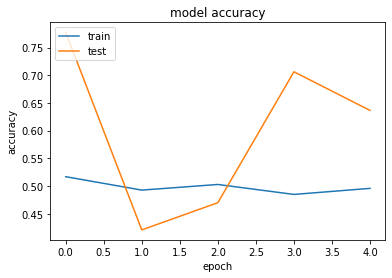

<Figure size 432x288 with 0 Axes>

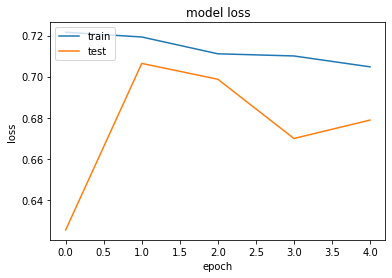

acc: 56.07%
[[217  75]
 [135  51]]
Train on 1279 samples, validate on 630 samples
Epoch 1/5
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7376 - acc: 0.5066 - val_loss: 0.7399 - val_acc: 0.3111
Epoch 2/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7259 - acc: 0.4801 - val_loss: 0.7247 - val_acc: 0.3159
Epoch 3/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7013 - acc: 0.5176 - val_loss: 0.7222 - val_acc: 0.2492
Epoch 4/5
1279/1279 [==============================] - 2s 1ms/step - loss: 0.6946 - acc: 0.5113 - val_loss: 0.7049 - val_acc: 0.4032
Epoch 5/5
478/478 [==============================] - 0s 608us/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 432x288 with 0 Axes>

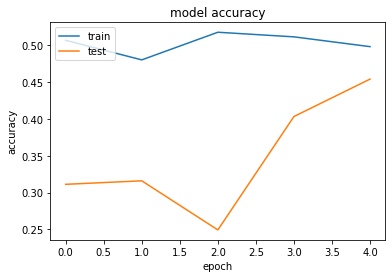

<Figure size 432x288 with 0 Axes>

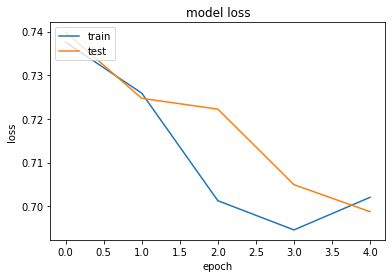

acc: 49.58%
[[156 136]
 [105  81]]
Train on 1279 samples, validate on 631 samples
Epoch 1/5
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7358 - acc: 0.4894 - val_loss: 0.6638 - val_acc: 0.6086
Epoch 2/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7196 - acc: 0.5129 - val_loss: 0.7043 - val_acc: 0.4406
Epoch 3/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7083 - acc: 0.4848 - val_loss: 0.6610 - val_acc: 0.6688
Epoch 4/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7058 - acc: 0.5254 - val_loss: 0.6200 - val_acc: 0.7781
Epoch 5/5
477/477 [==============================] - 0s 379us/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 432x288 with 0 Axes>

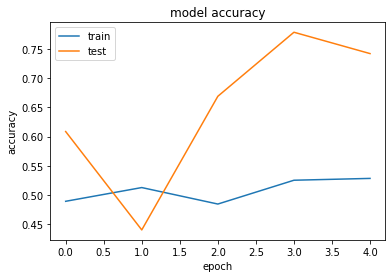

<Figure size 432x288 with 0 Axes>

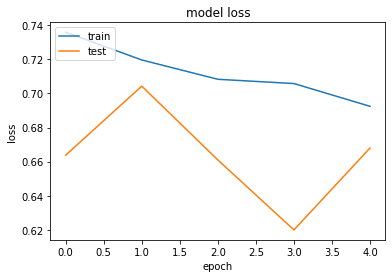

acc: 58.70%
[[276  15]
 [182   4]]
Train on 1279 samples, validate on 631 samples
Epoch 1/5
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7187 - acc: 0.5192 - val_loss: 0.7575 - val_acc: 0.2964
Epoch 2/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7148 - acc: 0.4879 - val_loss: 0.6740 - val_acc: 0.5848
Epoch 3/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7049 - acc: 0.5145 - val_loss: 0.6986 - val_acc: 0.4802
Epoch 4/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7054 - acc: 0.4894 - val_loss: 0.6881 - val_acc: 0.5531
Epoch 5/5
477/477 [==============================] - 0s 340us/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 432x288 with 0 Axes>

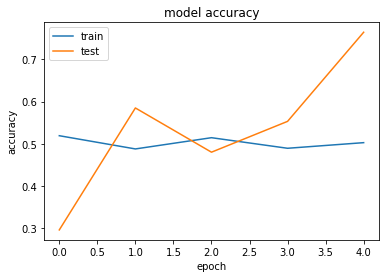

<Figure size 432x288 with 0 Axes>

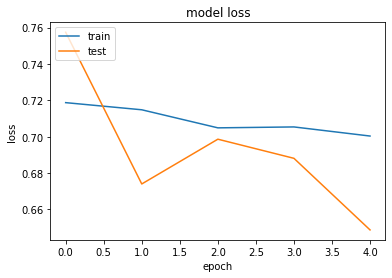

acc: 57.44%
[[249  42]
 [161  25]]
Train on 1279 samples, validate on 631 samples
Epoch 1/5
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7467 - acc: 0.4996 - val_loss: 0.5787 - val_acc: 0.7655
Epoch 2/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7147 - acc: 0.5121 - val_loss: 0.7023 - val_acc: 0.4739
Epoch 3/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.7076 - acc: 0.5035 - val_loss: 0.6530 - val_acc: 0.7179
Epoch 4/5
1279/1279 [==============================] - 2s 2ms/step - loss: 0.6912 - acc: 0.5356 - val_loss: 0.6920 - val_acc: 0.4469
Epoch 5/5
477/477 [==============================] - 0s 525us/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<Figure size 432x288 with 0 Axes>

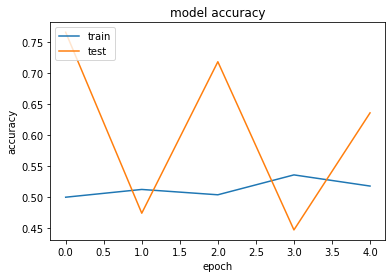

<Figure size 432x288 with 0 Axes>

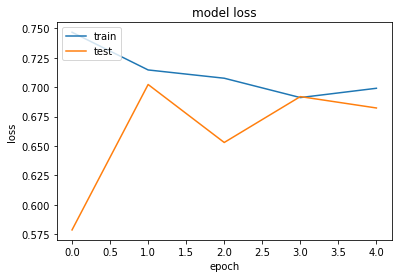

acc: 51.57%
[[203  88]
 [143  43]]
54.67% (+/- 3.50%)
average time spent on fitting for each cv with epoch=  5, batchsize=  100 is:  12.790730 seconds


<Figure size 432x288 with 0 Axes>

In [6]:
# Load the dataset we want
X=np.load('X.npy')
# y=np.load('y.npy')
# to make keras.to_categorical right, must label from 0!!!!!
# y=y-1
with open('y1_list.json') as infile:
    y1_list=json.load(infile)


    
# here, we merge label1 and label3 into  label 0
# label 1: happy =>0
# label 2: unhappy=>1
# label 3: neutral=>0
count_0=0
count_1=0
for idx, itm in enumerate(y1_list):
    if itm==1:
        y1_list[idx]=0
        count_0+=1
    if itm ==3:
        y1_list[idx]=0
        count_0+=1
    if itm==2:
        y1_list[idx]=1
        count_1+=1
#ratio of positive/negative=1457/(1457+930)=0.6103896103896104
print("num of 0:",count_0)
print("num of 1:",count_1)
print("ratio of positive/negative:",count_0/(count_0+count_1))
# print(y1_list)   

        
    
# set_trace()    


y=np.array(y1_list)


# Train and evalute the LSTM model using 10-fold cross-validation
folds,verbose, epochs, batch_size=5,1,5,100
cvscores,cvtime=LSTM_cv(folds,verbose, epochs, batch_size,X,y1_list,to_categorical(y))

# Print out the result to console
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % 8f seconds" % (epochs,batch_size,np.mean(cvtime)))

# Print out the result to txt
sample = open('results/office1and2_lstm_result.txt', 'w+') 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)), file = sample) 
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % .8f seconds" % (epochs,batch_size,np.mean(cvtime)), file = sample)
sample.close() 
print("Done!!!!")


In [7]:
%debug


ERROR:root:No traceback has been produced, nothing to debug.
